In [1]:
%pylab inline 

import gym
from gym import error, spaces, utils
from gym.utils import seeding
from collections import Counter
import time
import progressbar as pb

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM, Reshape, Dropout
from keras.optimizers import Adam

from rl.agents.cem import CEMAgent 
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory, EpisodeParameterMemory

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.
Using cuDNN version 7103 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
# load the market data
input_source = np.load(open('data_spy.npy','rb'))
to_predict = np.load(open('data_spy_targets.npy','rb'))

In [3]:
input_source.shape, to_predict.shape

((105, 16900), (4, 16900))

In [4]:
to_predict = to_predict[3,:].reshape(-1)

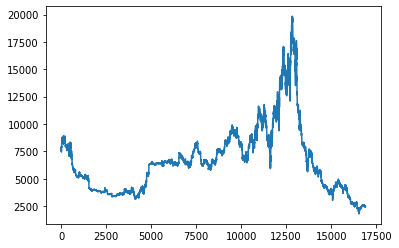

In [5]:
plot(to_predict);

In [6]:
input_source = input_source.T
input_source.shape

(16900, 105)

In [7]:
df=pd.DataFrame(input_source)

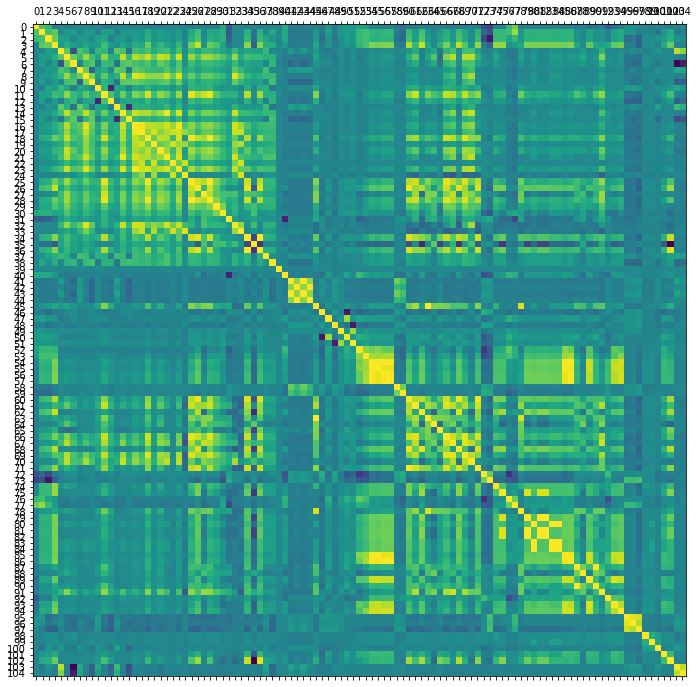

In [8]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

In [9]:
bars_per_episode = 1000
winlen = 10
class TradingEnv(gym.Env):
    
    """ This gym implements a simple trading environment for reinforcement learning. """
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        self.action_space = spaces.Discrete( 3 )
        self.observation_space= spaces.Box( #np.min(input_source, axis=0), 
                                            #np.max(input_source, axis=0)
                                            np.ones((winlen,input_source.shape[1], ))*-999999, 
                                            np.ones((winlen,input_source.shape[1], ))*999999, 
                                          )
        self.reset()
        
    def _configure(self, display=None):
        self.display = display

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        
        #assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        
        if (self.idx < self.end_idx) and (self.balance > 0):
            self.idx += 1
            done = False
        else:
            done = True
        
        info = {}
        
        observation = input_source[self.idx - winlen : self.idx, :]
        
        # execute the action and get the reward
        if action == 0 and self.position == 0: # buy 
            self.position = -1
            self.open_idx = self.idx
        if action == 1 and self.position == 0: # sell
            self.position = 1
            self.open_idx = self.idx
        if action == 2 or ((self.position==0) and ((self.idx - self.open_idx) > 8)): # close
            if self.position == -1: # long
                self.balance += (to_predict[self.idx] - to_predict[self.open_idx])*1000
            elif self.position == 1: # short
                self.balance += (to_predict[self.open_idx] - to_predict[self.idx])*1000
            self.position = 0
        if action == 3:
            pass
        
        reward = self.balance - self.prev_balance
        self.prev_balance = self.balance
        
        return observation, reward, done, info
    
    def reset(self):
        # reset and return first observation
        self.idx = np.random.randint(winlen+1, input_source.shape[0] - bars_per_episode)
        self.end_idx = self.idx + bars_per_episode
        self.position = 0
        self.open_idx = 0
        self.balance = 1000
        self.prev_balance = self.balance
        return input_source[self.idx - winlen : self.idx, :]
    
    def _render(self, mode='human', close=False):
        #... TODO
        pass        


In [10]:
env = TradingEnv()

In [11]:
env.observation_space.shape

(10, 105)

In [12]:
model = Sequential()
model.add(Reshape(env.observation_space.shape, input_shape=(1,) + env.observation_space.shape))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(env.action_space.n, activation='softmax'))

memory = EpisodeParameterMemory(10000, window_length=1)
policy = BoltzmannQPolicy()
cem = CEMAgent(model=model, 
               nb_actions=env.action_space.n, 
               memory=memory, 
               nb_steps_warmup=10,
               )
cem.compile()

In [13]:
# training is here
h = cem.fit(env, nb_steps=300000, nb_max_episode_steps=bars_per_episode, visualize=False, verbose=1)
rewards = h.history['episode_reward']

Training for 300000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: -538.1890
118 episodes - episode_reward: -45609.237 [-902970.000, 1300160.000] - mean_best_reward: 994770.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 33s 3ms/step - reward: 1940.2660
90 episodes - episode_reward: 208202.444 [-1524290.000, 19537280.000] - mean_best_reward: 5749135.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 33s 3ms/step - reward: 369.4920
98 episodes - episode_reward: 38543.367 [-1037000.000, 6239310.000] - mean_best_reward: 6088632.500

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 33s 3ms/step - reward: 353.7250
96 episodes - episode_reward: 37599.688 [-1121880.000, 8055010.000] - mean_best_reward: 735155.000

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 34s 3ms/step - reward: -522.3

ValueError: Error when checking input: expected reshape_1_input to have shape (1, 10, 105) but got array with shape (1, 0, 105)

In [ ]:
plot(rewards);

In [ ]:
# visualize the behavior for one random episode
observation = env.reset()
done = False
navs = []
while not done:
    action = cem.forward(observation)
    observation, reward, done, info = env.step(action)
    navs.append(reward)

kl = []
t = 0
for n in navs:
    t += n
    kl.append(t)
plot(kl);

In [ ]:
# calculate the likelihood of success for any given episode
l = 1000
krl = []
p = pb.ProgressBar(max_value=l)
for i in range(l):
    p.update(i)
    observation = env.reset()
    done = False
    navs = []
    while not done:
        action = cem.forward(observation)
        observation, reward, done, info = env.step(action)
        navs.append(reward)
    krl.append(sum(navs))
p.finish()

In [ ]:
krl = array(krl)
print('Profit likelihood: %3.3f%%' % (100*(sum(krl > 0) / len(krl))))